# 完全连接的神经网络
在之前的作业中，您在CIFAR-10上实现了一个完全连接的两层神经网络。实现简单，但不是很模块化，因为损失和梯度计算在一个单一的单一功能。对于一个简单的两层网络来说，这是可以管理的，但是当我们转向更大的模型时，这就变得不切实际了。理想情况下，我们希望使用更模块化的设计来构建网络，这样我们就可以独立地实现不同的层类型，然后将它们整合到具有不同架构的模型中。

在本练习中，我们将使用更模块化的方法实现全连接网络。对于每一层，我们将实现“向前”和“向后”功能。“向前”函数将接收输入、权重和其他参数，并返回一个输出和一个“缓存”对象，存储后向传递所需的数据，如下所示:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

反向传递将接收上游导数和“缓存”对象，并返回与输入和权重相关的梯度，如下所示:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

以这种方式实现了一堆层之后，我们将能够轻松地将它们组合起来，以构建具有不同架构的分类器。

除了实现任意深度的全连通网络，我们还将探索不同的优化更新规则，并引入Dropout作为正则化器和Batch归一化工具来更有效地优化深度网络。
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# 仿射层:向前
打开文件`cs231n/layers`并实现`affine_forward`函数。

一旦你做了，你可以测试你的实现通过运行以下:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# 仿射层:向后
现在实现`affine_backwards函数`，并使用数值梯度检查测试您的实现。

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU层:前向
在`relu_forward`函数中实现ReLU激活函数的转发，并使用以下方法测试您的实现:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU层:向后
现在在`relu_back`函数中为ReLU激活函数执行反向遍历，并使用数值梯度检查来测试您的实现:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# “三明治”层
在神经网络中有一些常用的层模式。例如，仿射层后面经常跟一个ReLU非线性。为了简化这些常见模式，我们在文件`cs231n/layer_utils.py`中定义了几个方便的层。

现在看一下` affine_relu_forward `和`affine_relu_back `函数，并运行以下代码来检查后向遍历:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# 损失层:Softmax和SVM
你在上次作业中实现了这些损失函数，所以我们会在这里免费给你。您仍然应该通过查看`cs231n/layers.py`中的实现来确保理解它们是如何工作的。

你可以通过运行以下程序来确保实现是正确的:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# 两层网络
在之前的作业中，您在一个单片类中实现了一个两层神经网络。现在您已经实现了必要层的模块版本，您将使用这些模块实现重新实现这两层网络。

打开文件`cs231n/classifiers/fc_net`完成`TwoLayerNet`类的实现。这个类将作为在这个作业中要实现的其他网络的模型，所以请通读它以确保您理解了这个API。您可以运行下面的单元来测试您的实现。

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 7.98e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# 求解器
在之前的作业中，训练模型的逻辑与模型本身是耦合的。按照更加模块化的设计，在这次作业中，我们将训练模型的逻辑划分为单独的类。

打开文件`cs231n/solver`然后通读一遍以熟悉API。这样做之后，使用一个“求解器”实例来训练一个`TwoLayerNet`，它在验证集上达到至少“50%”的精度。

In [10]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

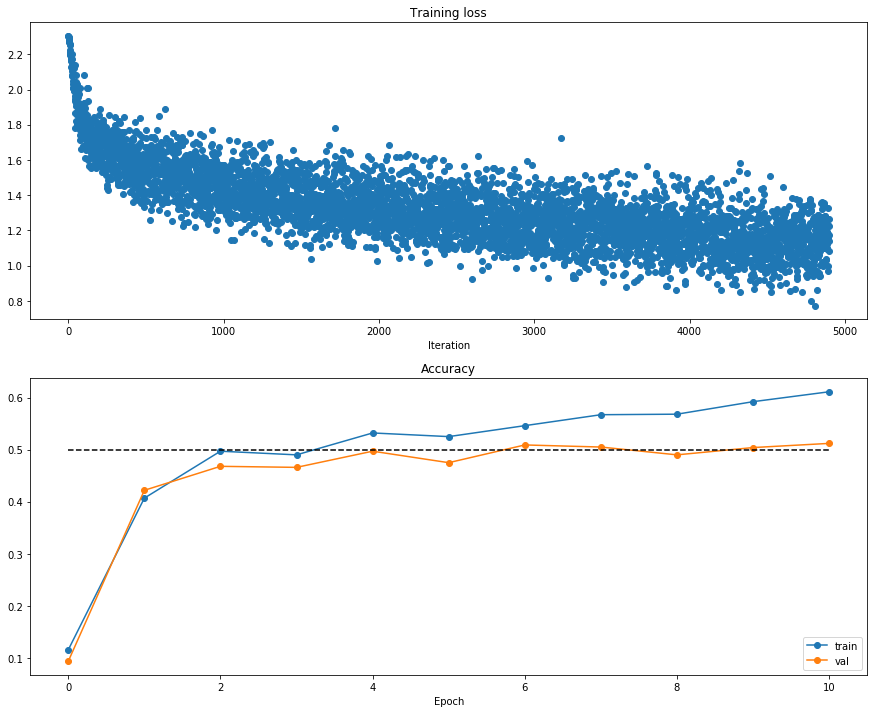

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# 多层网络
接下来，您将实现一个具有任意数量隐藏层的全连接网络。

读取文件`cs231n/classifier /fc_net.py`中的`FullyConnectedNet`类。

实现初始化、向前传递和向后传递。目前，不必担心实现dropout或批处理标准化;我们将很快添加这些功能。

## 初始损失和梯度检查

作为一种完整性检查，运行以下命令来检查初始损失，并对有正则化和无正则化的网络进行梯度检查。最初的损失合理吗?

对于梯度检查，您应该期望在1e-6或更少的地方看到错误。

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


作为另一个完整性检查，请确保您可以过度适合50个图像的小数据集。首先，我们将尝试一个三层网络，每层100个单位。您将需要调整学习速率和初始化规模，但您应该能够在20个epoch内超额拟合并实现100%的训练精度。

(Iteration 1 / 40) loss: 357.428290
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.111000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.081000
(Epoch 3 / 20) train acc: 0.040000; val_acc: 0.097000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.107000
(Iteration 11 / 40) loss: 4062748033166512669146890481179922634050366887028969624284570245514046405899939850369081499364981021366493904896.000000
(Epoch 6 / 20) train acc: 0.120000; val_acc: 0.119000


C:\Users\hanlu\Desktop\CS231n\assignment2\cs231n\layers.py:686: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)
C:\Users\hanlu\Desktop\CS231n\assignment2\cs231n\classifiers\fc_net.py:302: RuntimeWarning: overflow encountered in multiply
  self.params['W' + str(self.num_layers)] * self.params['W' + str(self.num_layers)])
C:\Users\hanlu\Desktop\CS231n\assignment2\cs231n\classifiers\fc_net.py:302: RuntimeWarning: invalid value encountered in double_scalars
  self.params['W' + str(self.num_layers)] * self.params['W' + str(self.num_layers)])
C:\Users\hanlu\Desktop\CS231n\assignment2\cs231n\classifiers\fc_net.py:311: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * self.reg * np.sum(self.params['W' + str(i)] * self.params['W' + str(i)])
C:\Users\hanlu\Desktop\CS231n\assignment2\cs231n\classifiers\fc_net.py:311: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * self.reg * np.sum(self.params

(Epoch 7 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 8 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 9 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 10 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 21 / 40) loss: nan
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.087000
(Iteration 31 / 40) loss: nan
(Epoch 16 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 17 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 18 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 19 / 20) train acc: 0.080000; val_acc: 0.087000
(Epoch 20 / 20) train acc: 0.080000; val_acc: 0.087000
weight_scale 1.000000e-01 learning_rate 1.000000e-02 


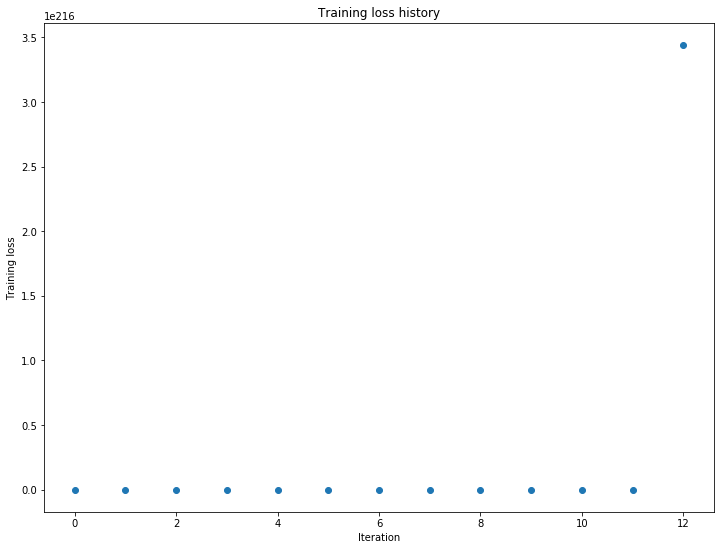

(Iteration 1 / 40) loss: 2.375113
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.091000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.096000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.152000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.620000; val_acc: 0.165000
(Epoch 5 / 20) train acc: 0.620000; val_acc: 0.158000
(Iteration 11 / 40) loss: 1.094711
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.173000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.171000
(Epoch 8 / 20) train acc: 0.860000; val_acc: 0.172000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.198000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.183000
(Iteration 21 / 40) loss: 0.278962
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.196000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.169000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.177000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.187000
(Iteration 31 / 40) loss: 

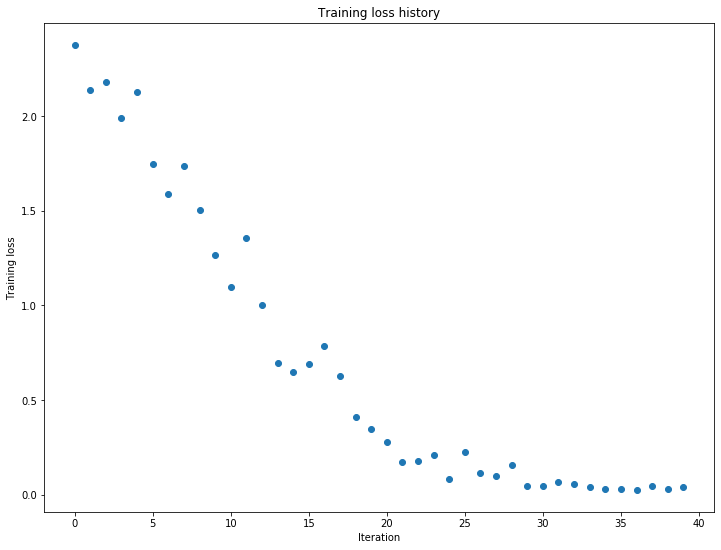

(Iteration 1 / 40) loss: 188.174619
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.150000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.156000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.153000
(Epoch 4 / 20) train acc: 0.780000; val_acc: 0.172000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.174000
(Iteration 11 / 40) loss: 5.796408
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.176000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.179000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.179000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.179000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.179000
(Iteration 21 / 40) loss: 0.000000
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.179000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.172000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.172000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.170000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.170000
(Iteration 31 / 40) loss

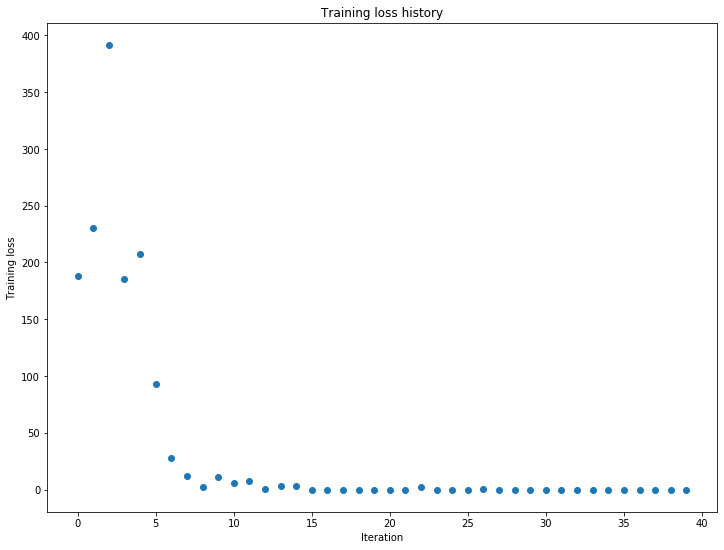

(Iteration 1 / 40) loss: 2.385904
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.060000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.058000
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.073000
(Epoch 3 / 20) train acc: 0.220000; val_acc: 0.083000
(Epoch 4 / 20) train acc: 0.280000; val_acc: 0.096000
(Epoch 5 / 20) train acc: 0.400000; val_acc: 0.106000
(Iteration 11 / 40) loss: 2.209372
(Epoch 6 / 20) train acc: 0.460000; val_acc: 0.109000
(Epoch 7 / 20) train acc: 0.420000; val_acc: 0.105000
(Epoch 8 / 20) train acc: 0.500000; val_acc: 0.117000
(Epoch 9 / 20) train acc: 0.520000; val_acc: 0.124000
(Epoch 10 / 20) train acc: 0.540000; val_acc: 0.124000
(Iteration 21 / 40) loss: 1.987063
(Epoch 11 / 20) train acc: 0.540000; val_acc: 0.126000
(Epoch 12 / 20) train acc: 0.560000; val_acc: 0.121000
(Epoch 13 / 20) train acc: 0.580000; val_acc: 0.122000
(Epoch 14 / 20) train acc: 0.600000; val_acc: 0.124000
(Epoch 15 / 20) train acc: 0.580000; val_acc: 0.118000
(Iteration 31 / 40) loss: 

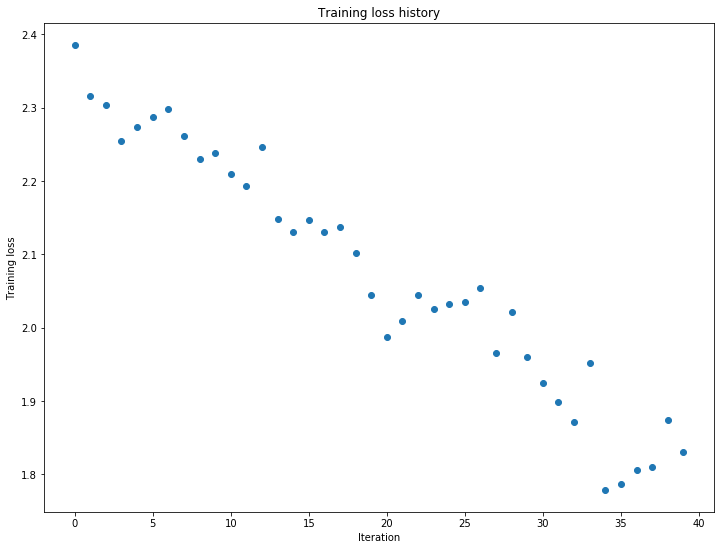

(Iteration 1 / 40) loss: 280.715356
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.102000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.103000
(Epoch 3 / 20) train acc: 0.100000; val_acc: 0.082000
(Epoch 4 / 20) train acc: 0.120000; val_acc: 0.100000
(Epoch 5 / 20) train acc: 0.080000; val_acc: 0.107000
(Iteration 11 / 40) loss: 20065809002631822579742614635937792.000000
(Epoch 6 / 20) train acc: 0.060000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.100000; val_acc: 0.103000
(Epoch 8 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 9 / 20) train acc: 0.100000; val_acc: 0.102000
(Epoch 10 / 20) train acc: 0.100000; val_acc: 0.102000
(Iteration 21 / 40) loss: 2.300902
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc:

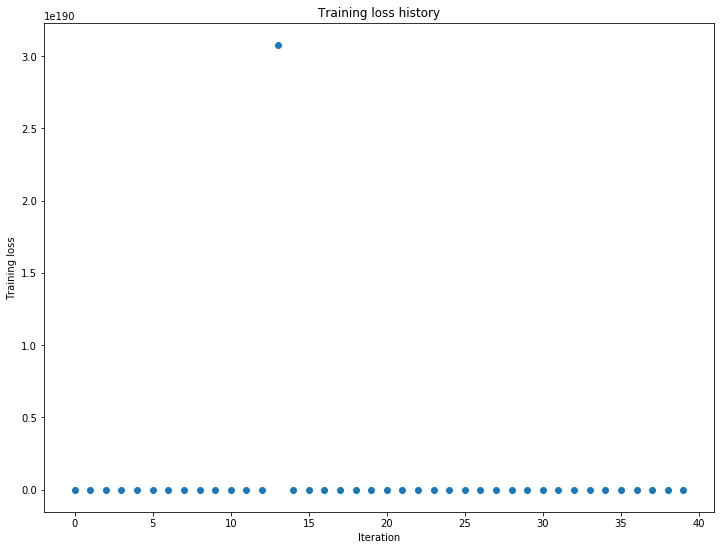

(Iteration 1 / 40) loss: 2.305551
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.123000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.118000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.168000
(Epoch 3 / 20) train acc: 0.420000; val_acc: 0.161000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.173000
(Epoch 5 / 20) train acc: 0.620000; val_acc: 0.160000
(Iteration 11 / 40) loss: 1.238117
(Epoch 6 / 20) train acc: 0.600000; val_acc: 0.184000
(Epoch 7 / 20) train acc: 0.680000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.760000; val_acc: 0.185000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.202000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.189000
(Iteration 21 / 40) loss: 0.627668
(Epoch 11 / 20) train acc: 0.920000; val_acc: 0.186000
(Epoch 12 / 20) train acc: 0.880000; val_acc: 0.166000
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.167000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.185000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.185000
(Iteration 31 / 40) loss: 

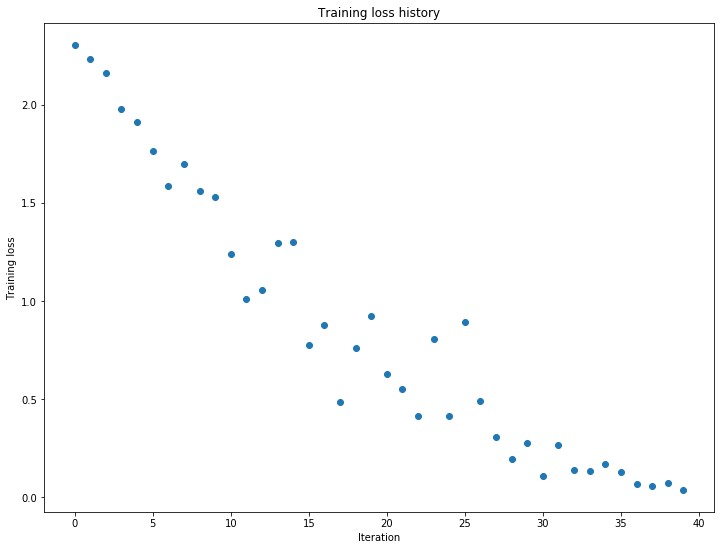

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
weight_scales = [1e-1,1e-2]
learning_rates = [1e-2,1e-3, 8e-3]
for learning_rate in learning_rates:
    for weight_scale in weight_scales:
        model = FullyConnectedNet([100, 100],
                      weight_scale=weight_scale, dtype=np.float64)
        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': learning_rate,
                        }
                 )
        solver.train()
        print("="*50)
        print("weight_scale %e learning_rate %e "%(weight_scale,learning_rate))
        plt.plot(solver.loss_history, 'o')
        plt.title('Training loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Training loss')
        plt.show()

现在尝试使用一个五层的网络，每层100个单位，以适应50个训练的例子。同样地，您将不得不调整学习速率和权重初始化，但是您应该能够在20个epoch内实现100%的训练精度。

(Iteration 1 / 40) loss: 77.617295
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.122000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.115000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.091000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.117000
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.116000
(Iteration 11 / 40) loss: 0.000802
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.119000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.114000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.113000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.118000
(Iteration 21 / 40) loss: 0.000527
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.118000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.118000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.118000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.118000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.118000
(Iteration 31 / 40) loss:

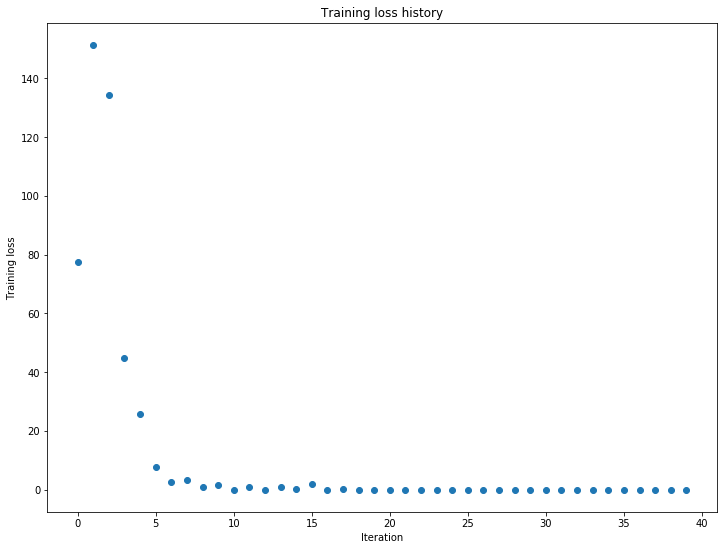

(Iteration 1 / 40) loss: 145.927326
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.091000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.117000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.580000; val_acc: 0.120000
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.138000
(Iteration 11 / 40) loss: 3.750227
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.146000
(Epoch 7 / 20) train acc: 0.860000; val_acc: 0.142000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.138000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.135000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.140000
(Iteration 21 / 40) loss: 0.141620
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.147000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.145000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.139000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.138000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.138000
(Iteration 31 / 40) loss

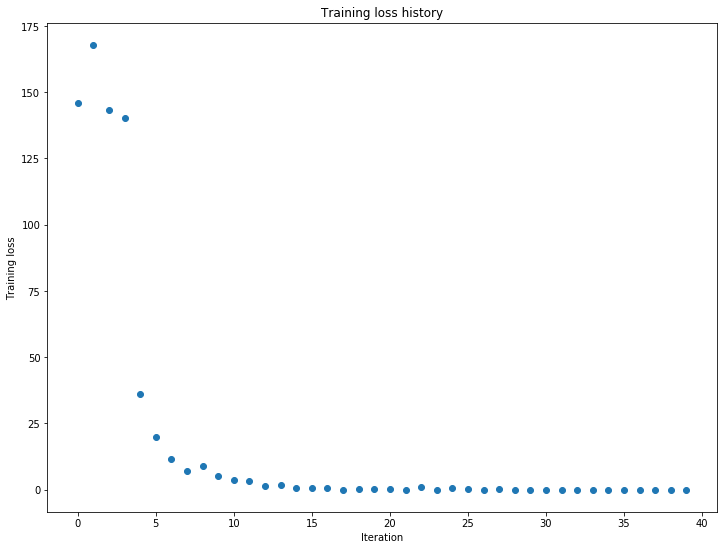

(Iteration 1 / 40) loss: 107.525356
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.086000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.115000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.137000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.103000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.124000
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.118000
(Iteration 11 / 40) loss: 12.933813
(Epoch 6 / 20) train acc: 0.700000; val_acc: 0.111000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.123000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.118000
(Epoch 9 / 20) train acc: 0.900000; val_acc: 0.113000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.111000
(Iteration 21 / 40) loss: 0.000457
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.111000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.116000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.114000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.111000
(Iteration 31 / 40) los

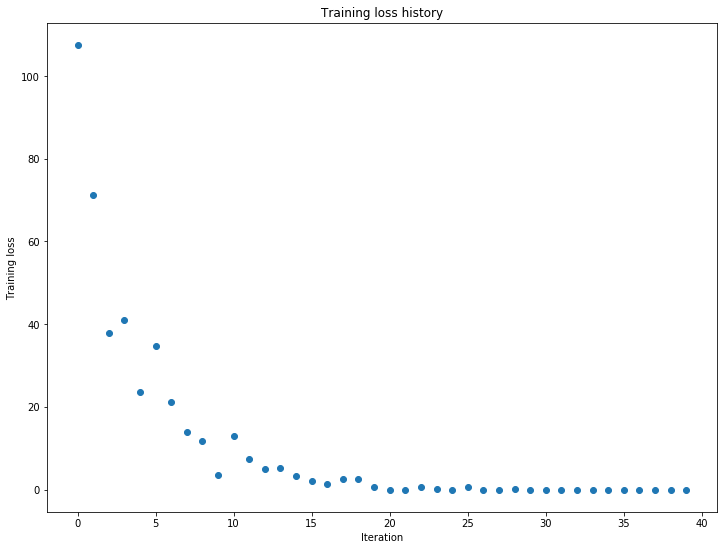

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
weight_scales=[1e-1]
learning_rates=[1e-3, 2e-3, 2e-4]
for learning_rate in learning_rates:
    for weight_scale in weight_scales:
        model = FullyConnectedNet([100, 100, 100, 100],
                        weight_scale=weight_scale, dtype=np.float64)
        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': learning_rate,
                        }
                 )
        solver.train()
        print("="*50)
        print("weight_scale %e learning_rate %e "%(weight_scale,learning_rate))
        plt.plot(solver.loss_history, 'o')
        plt.title('Training loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Training loss')
        plt.show()

# Inline question: 
你注意到训练三层网和训练五层网的相对难度了吗?

# Answer:  
*fill in this*

五层网络对参数初始化更加敏感，收敛和变化幅度相比三层网络大很多

# 更新规则
到目前为止，我们已经使用了普通的随机梯度下降法(SGD)作为我们的更新规则。更复杂的更新规则可以更容易地训练深度网络。我们将实现一些最常用的更新规则，并将它们与普通的SGD进行比较。

# SGD+Momentum
具有动量的随机梯度下降法是一种广泛应用的更新规则，它使深部网络的收敛速度快于普通的随机梯度下降法。

打开文件`cs231n/optim`，并阅读文件顶部的文档，以确保您理解了该API。在函数“sgd_momentum”中实现SSGD+Momentum更新规则，并运行以下命令检查实现。您应该看到错误小于1e-8。

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


一旦你这样做了，运行以下来训练一个具有SGD和SGD+Momentum的六层网络。你应该看到SGD+Momentum更新规则收敛得更快。

running with  sgd
(Iteration 1 / 200) loss: 2.482885
(Epoch 0 / 5) train acc: 0.115000; val_acc: 0.134000
(Iteration 11 / 200) loss: 2.212039
(Iteration 21 / 200) loss: 2.119283
(Iteration 31 / 200) loss: 2.088308
(Epoch 1 / 5) train acc: 0.279000; val_acc: 0.247000
(Iteration 41 / 200) loss: 2.009054
(Iteration 51 / 200) loss: 1.953987
(Iteration 61 / 200) loss: 2.069506
(Iteration 71 / 200) loss: 1.891622
(Epoch 2 / 5) train acc: 0.333000; val_acc: 0.271000
(Iteration 81 / 200) loss: 1.958631
(Iteration 91 / 200) loss: 1.945542
(Iteration 101 / 200) loss: 1.762355
(Iteration 111 / 200) loss: 1.866230
(Epoch 3 / 5) train acc: 0.319000; val_acc: 0.306000
(Iteration 121 / 200) loss: 1.755194
(Iteration 131 / 200) loss: 1.825922
(Iteration 141 / 200) loss: 1.723891
(Iteration 151 / 200) loss: 1.689054
(Epoch 4 / 5) train acc: 0.399000; val_acc: 0.314000
(Iteration 161 / 200) loss: 1.682975
(Iteration 171 / 200) loss: 1.781320
(Iteration 181 / 200) loss: 1.593739
(Iteration 191 / 200) los

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

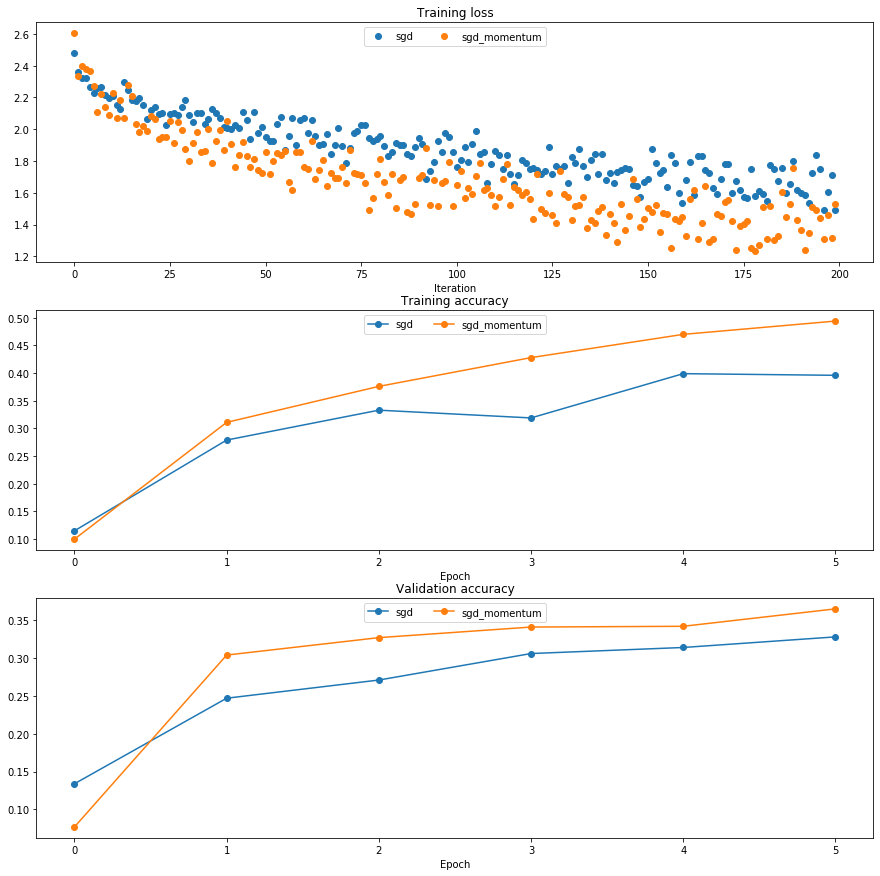

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] 和Adam [2] ，它们通过使用梯度的第二个时刻的运行平均值来设置每个参数的学习速率。
在文件`cs231n/optim`中在`RMSProp`函数中实现RMSProp更新规则，在`Adam`函数中实现Adam更新规则，并使用下面的测试来检查您的实现。

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [18]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.20720703668629928
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


一旦你调试了你的RMSProp和Adam实现，运行下面的代码来使用这些新的更新规则来训练一对深层网络:

running with  adam
(Iteration 1 / 200) loss: 3.198212
(Epoch 0 / 5) train acc: 0.131000; val_acc: 0.144000
(Iteration 11 / 200) loss: 2.276926
(Iteration 21 / 200) loss: 2.088783
(Iteration 31 / 200) loss: 2.089586
(Epoch 1 / 5) train acc: 0.278000; val_acc: 0.272000
(Iteration 41 / 200) loss: 2.031683
(Iteration 51 / 200) loss: 1.809372
(Iteration 61 / 200) loss: 1.890397
(Iteration 71 / 200) loss: 1.920178
(Epoch 2 / 5) train acc: 0.333000; val_acc: 0.298000
(Iteration 81 / 200) loss: 1.631650
(Iteration 91 / 200) loss: 1.674013
(Iteration 101 / 200) loss: 1.748246
(Iteration 111 / 200) loss: 1.708306
(Epoch 3 / 5) train acc: 0.411000; val_acc: 0.350000
(Iteration 121 / 200) loss: 1.864546
(Iteration 131 / 200) loss: 1.692495
(Iteration 141 / 200) loss: 1.580489
(Iteration 151 / 200) loss: 1.515855
(Epoch 4 / 5) train acc: 0.408000; val_acc: 0.352000
(Iteration 161 / 200) loss: 1.622686
(Iteration 171 / 200) loss: 1.497883
(Iteration 181 / 200) loss: 1.593961
(Iteration 191 / 200) lo

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

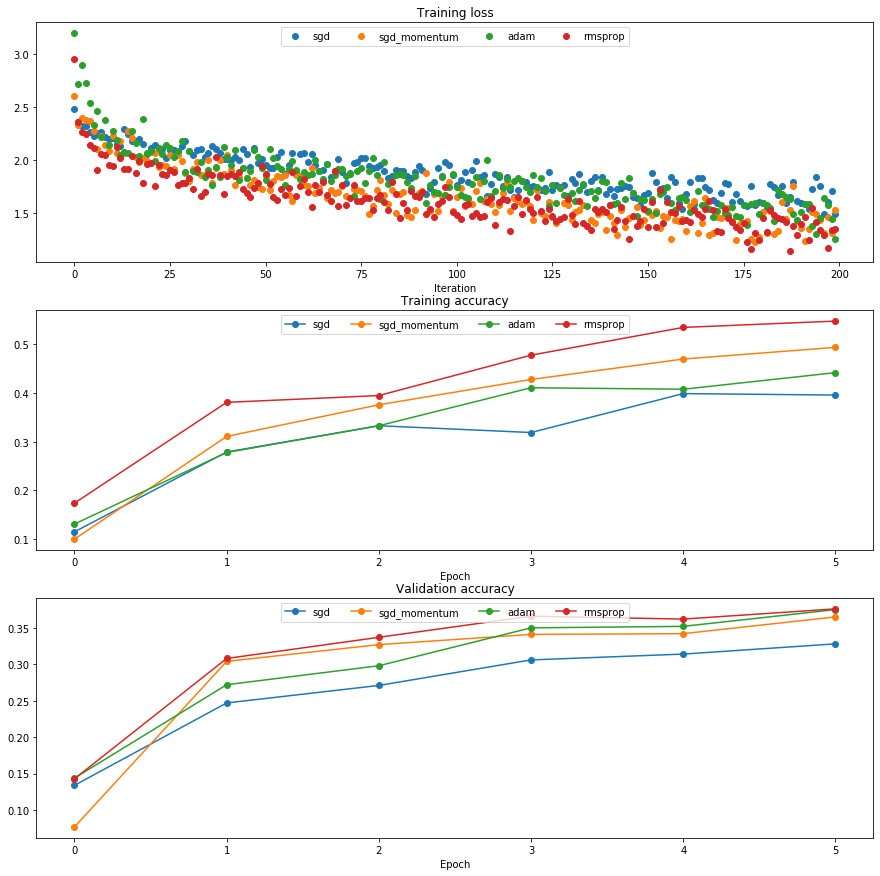

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# 训练一个好的模型!
在CIFAR-10上尽可能训练最好的全连接模型，将最好的模型存储在`best_model`变量中。我们要求您在使用全网连接的验证集上获得至少50%的准确性。

如果你小心，它应该是有可能得到精度55%以上，但我们不要求它为这部分，也不会分配额外的学分这样做。在作业的后面，我们会要求你们在CIFAR-10上尽可能地训练最好的卷积网络，我们希望你们把精力放在卷积网络上，而不是全连接网络上。

您可能会发现完成`BatchNormalization.ipynb` and `Dropout.ipynb` 非常有用。在完成这部分之前，我先温习一下笔记本，因为这些技术可以帮助你训练强大的模型。

(Iteration 1 / 2450) loss: 2.339706
(Epoch 0 / 5) train acc: 0.106000; val_acc: 0.111000
(Epoch 1 / 5) train acc: 0.513000; val_acc: 0.460000
(Iteration 501 / 2450) loss: 1.641750
(Epoch 2 / 5) train acc: 0.559000; val_acc: 0.503000
(Iteration 1001 / 2450) loss: 1.311759
(Epoch 3 / 5) train acc: 0.600000; val_acc: 0.506000
(Iteration 1501 / 2450) loss: 1.153394
(Epoch 4 / 5) train acc: 0.659000; val_acc: 0.530000
(Iteration 2001 / 2450) loss: 1.058192
(Epoch 5 / 5) train acc: 0.697000; val_acc: 0.528000


D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

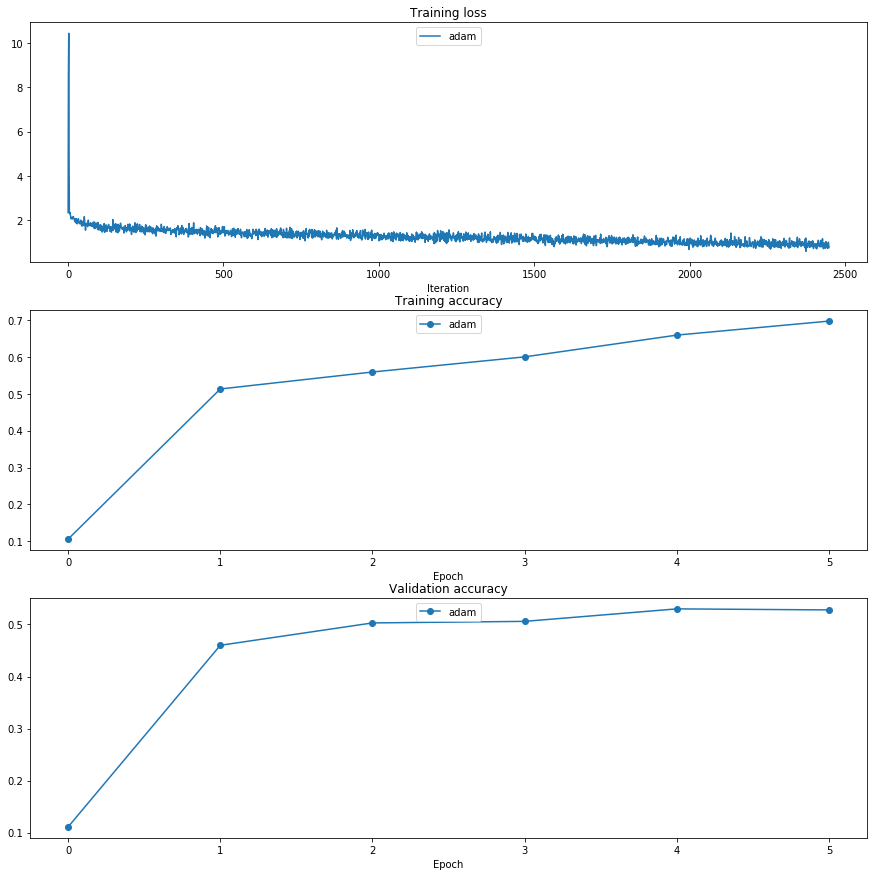

In [20]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
weight_scale = 2.5e-2
learning_rate = 3.1e-4
update_rule='adam'
model = FullyConnectedNet([600, 500, 400, 300, 200], weight_scale=weight_scale)

solver = Solver(model, data,
                print_every=500, num_epochs=5, batch_size=100,
                update_rule='rmsprop',
                optim_config={
                'learning_rate': learning_rate
                },
                lr_decay=0.9,
                verbose=True)
solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, label=update_rule)
  
plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label=update_rule)

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

best_model = model

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# 测试你的模型
在验证和测试集上运行您的最佳模型。验证集的准确率应达到50%以上。

In [21]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.53
Test set accuracy:  0.555
